In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_12DLorenz.recursive_Markovian_PostMeanScore_12DLorenz_Chaos_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 1024
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [7]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DLnzChaosLessData/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "MSE" in file and "bwidx" not in file:
                mses = pd.read_parquet(root_nadaraya_dir+file)
                mses["bw"] = [mses["bw"].loc[i][0] for i in mses.index]
                print(mses)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [9]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)
len(bws)

35

AttributeError: 'list' object has no attribute 'plot'

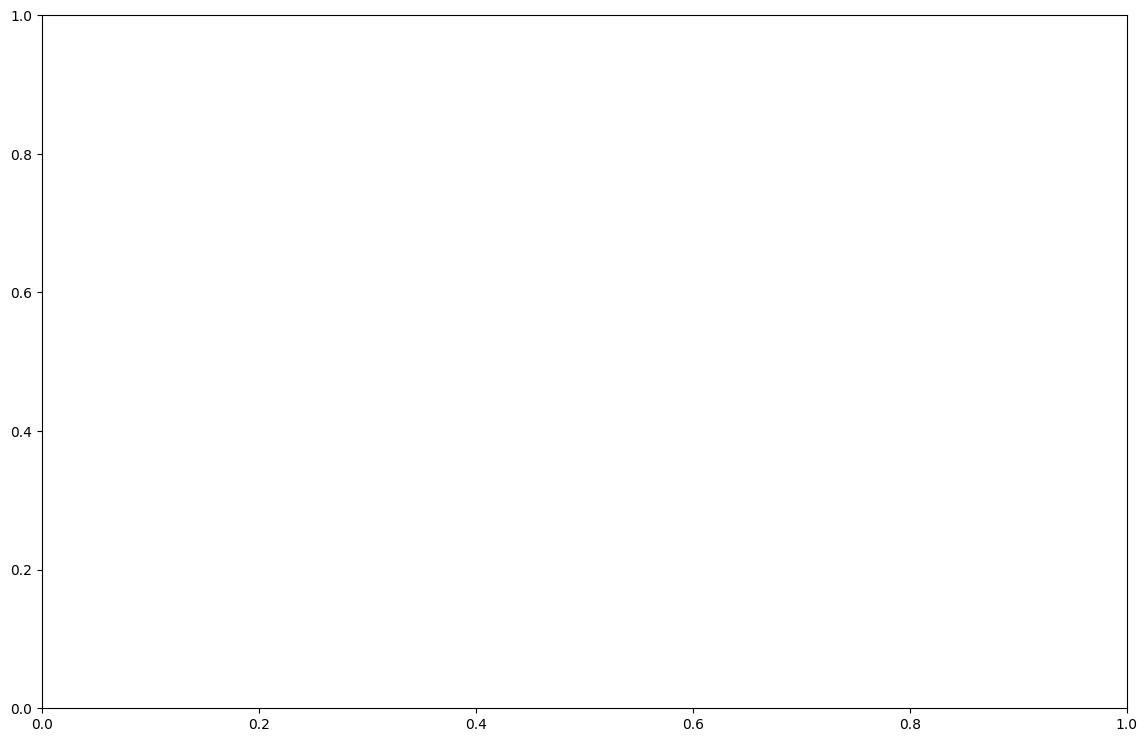

In [10]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 0], mses.iloc[np.argmin(mses.mse), 1]}")

13.122562691783916 0.0007912 inf


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_31893/3039973056.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_31893/3039973056.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


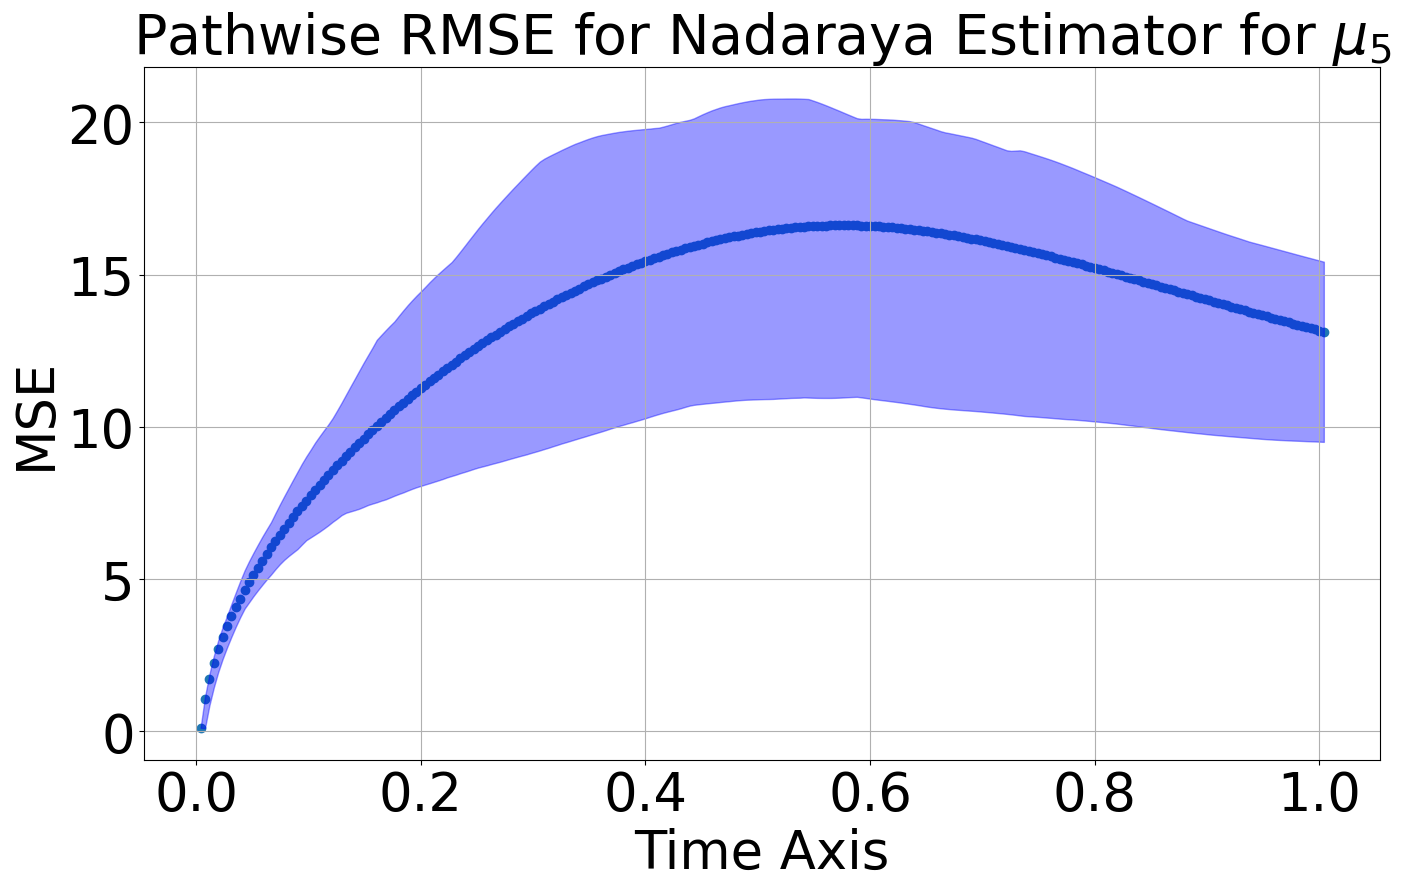

Final time cumulative MSE local-time error 13.122562691783916 with IQR ((9.505180939676963, 15.42395509453179))at bw 0.0007912 for 1.25FConst

13.119929768617947 0.0010446 13.122562691783916


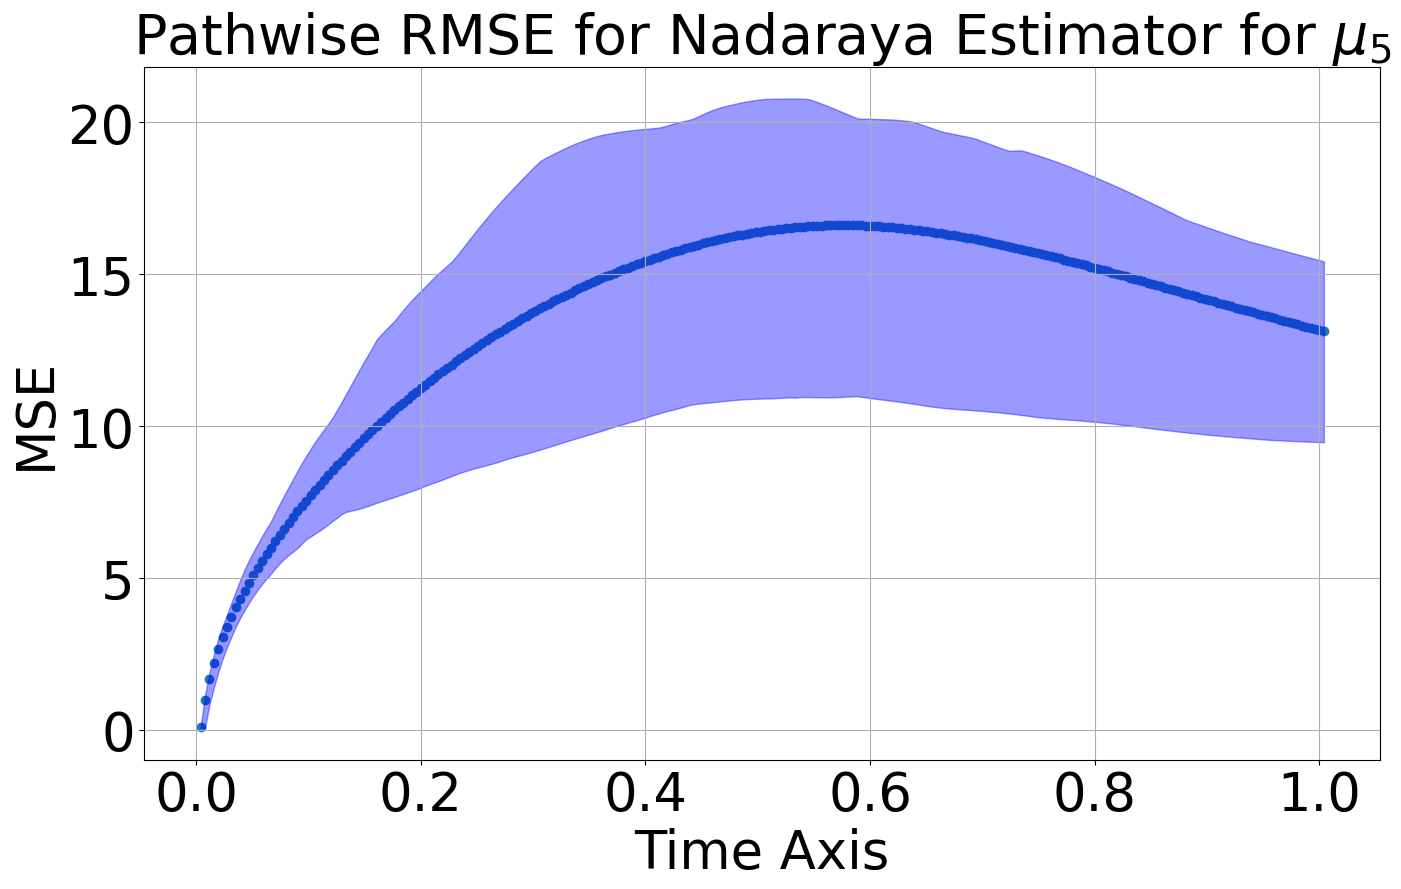

Final time cumulative MSE local-time error 13.119929768617947 with IQR ((9.468997376516246, 15.424500641296403))at bw 0.0010446 for 1.25FConst

13.102658899874632 0.0013793 13.119929768617947


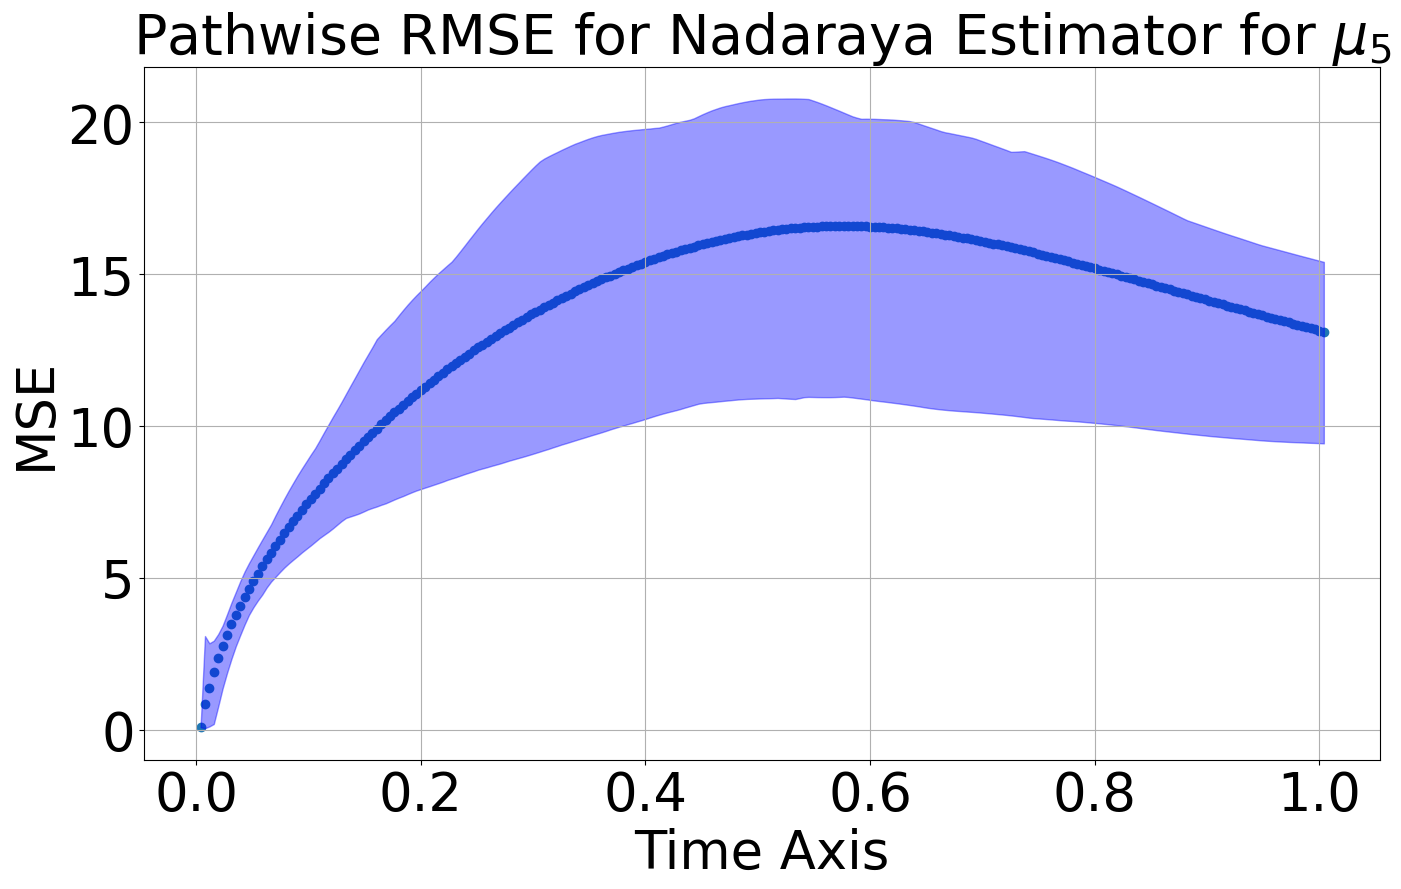

Final time cumulative MSE local-time error 13.102658899874632 with IQR ((9.426397497759178, 15.404144745612124))at bw 0.0013793 for 1.25FConst

13.073544649717666 0.0018211 13.102658899874632


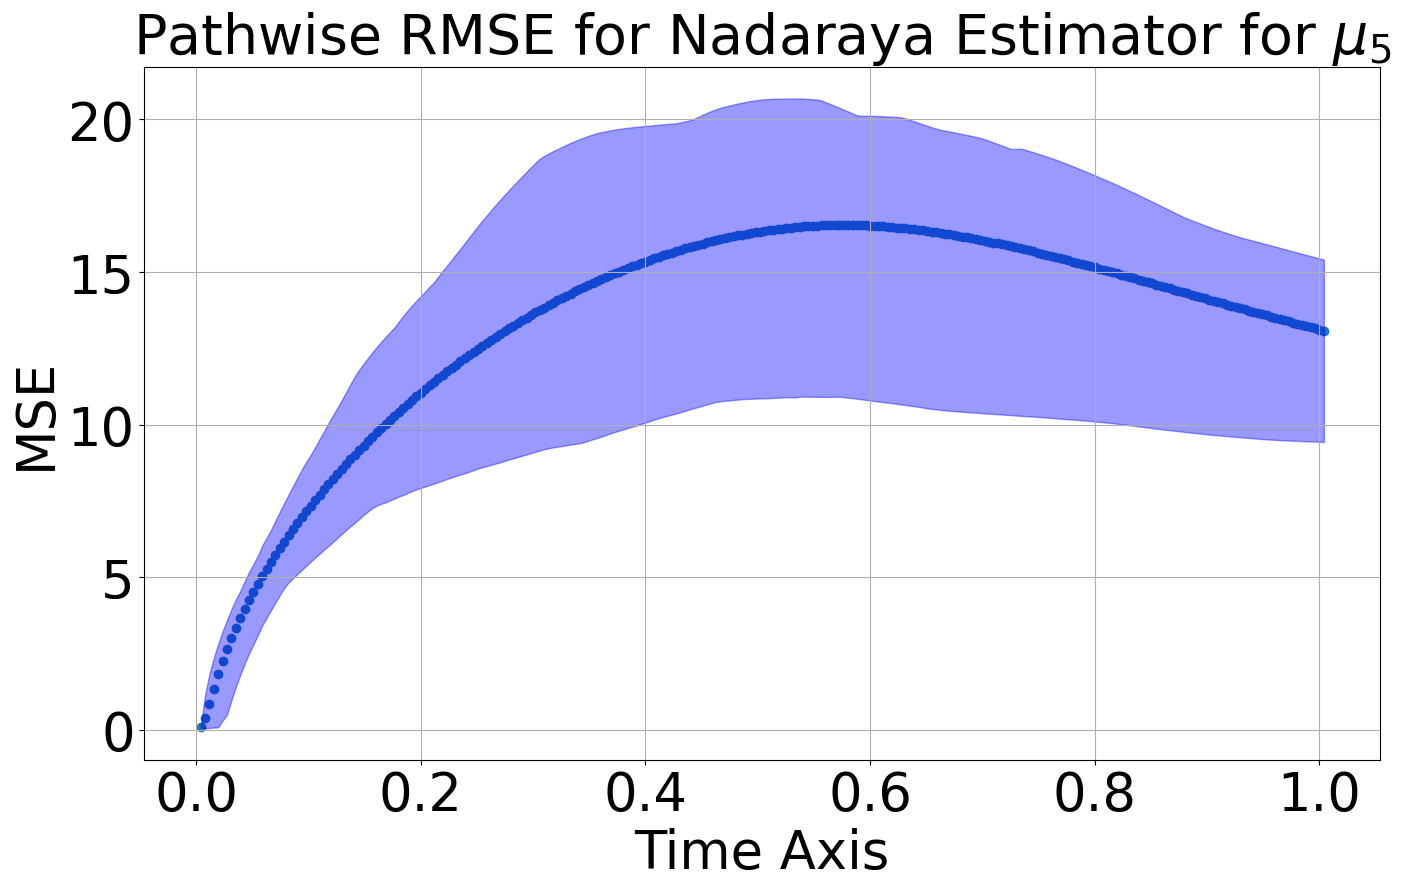

Final time cumulative MSE local-time error 13.073544649717666 with IQR ((9.426880017876398, 15.404664296936184))at bw 0.0018211 for 1.25FConst

13.020665449430854 0.0024046 13.073544649717666


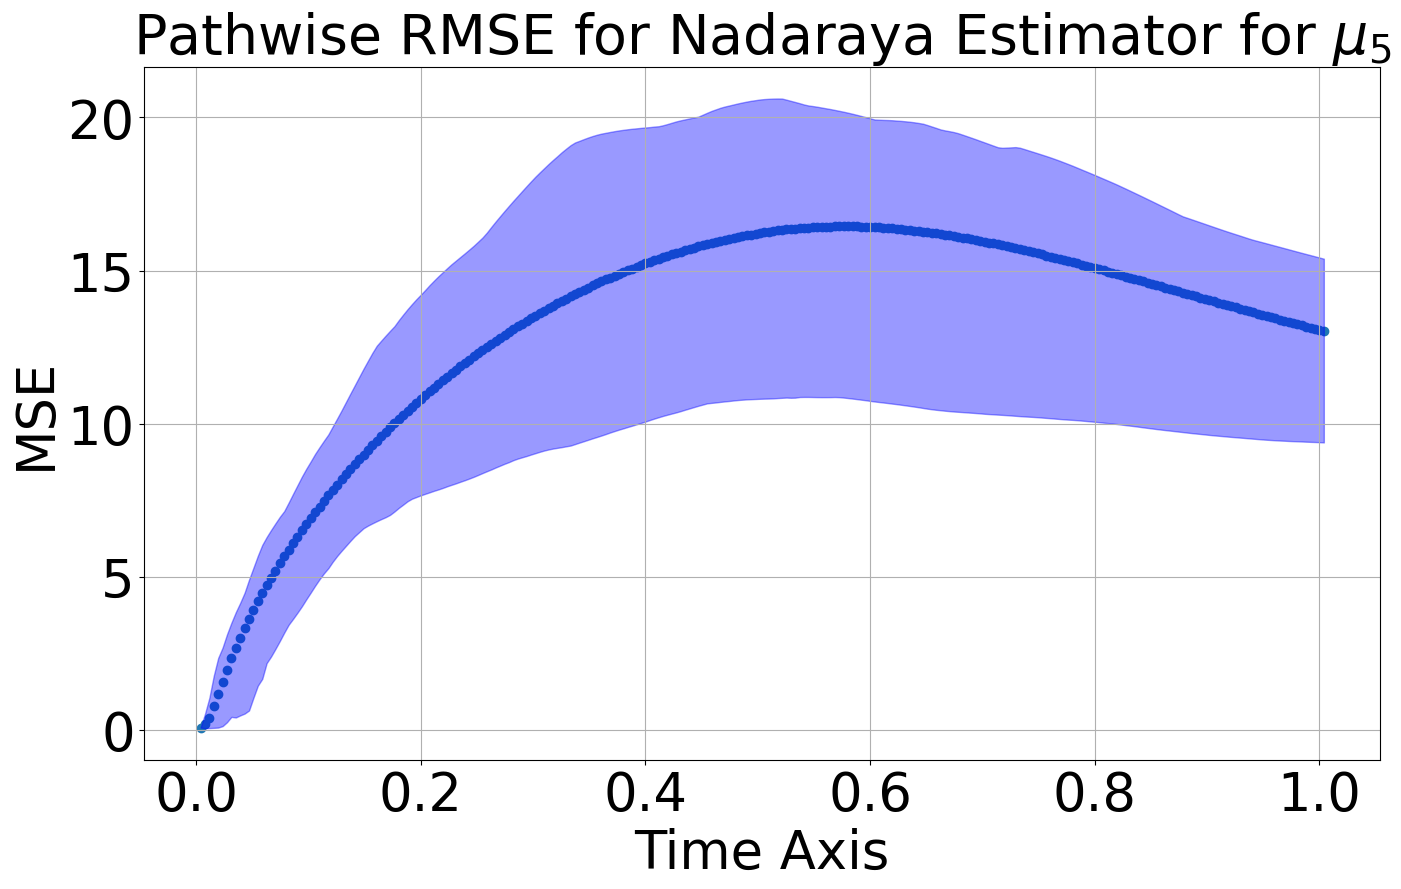

Final time cumulative MSE local-time error 13.020665449430854 with IQR ((9.38600079992889, 15.387365171816384))at bw 0.0024046 for 1.25FConst

12.930827041875782 0.0031749 13.020665449430854


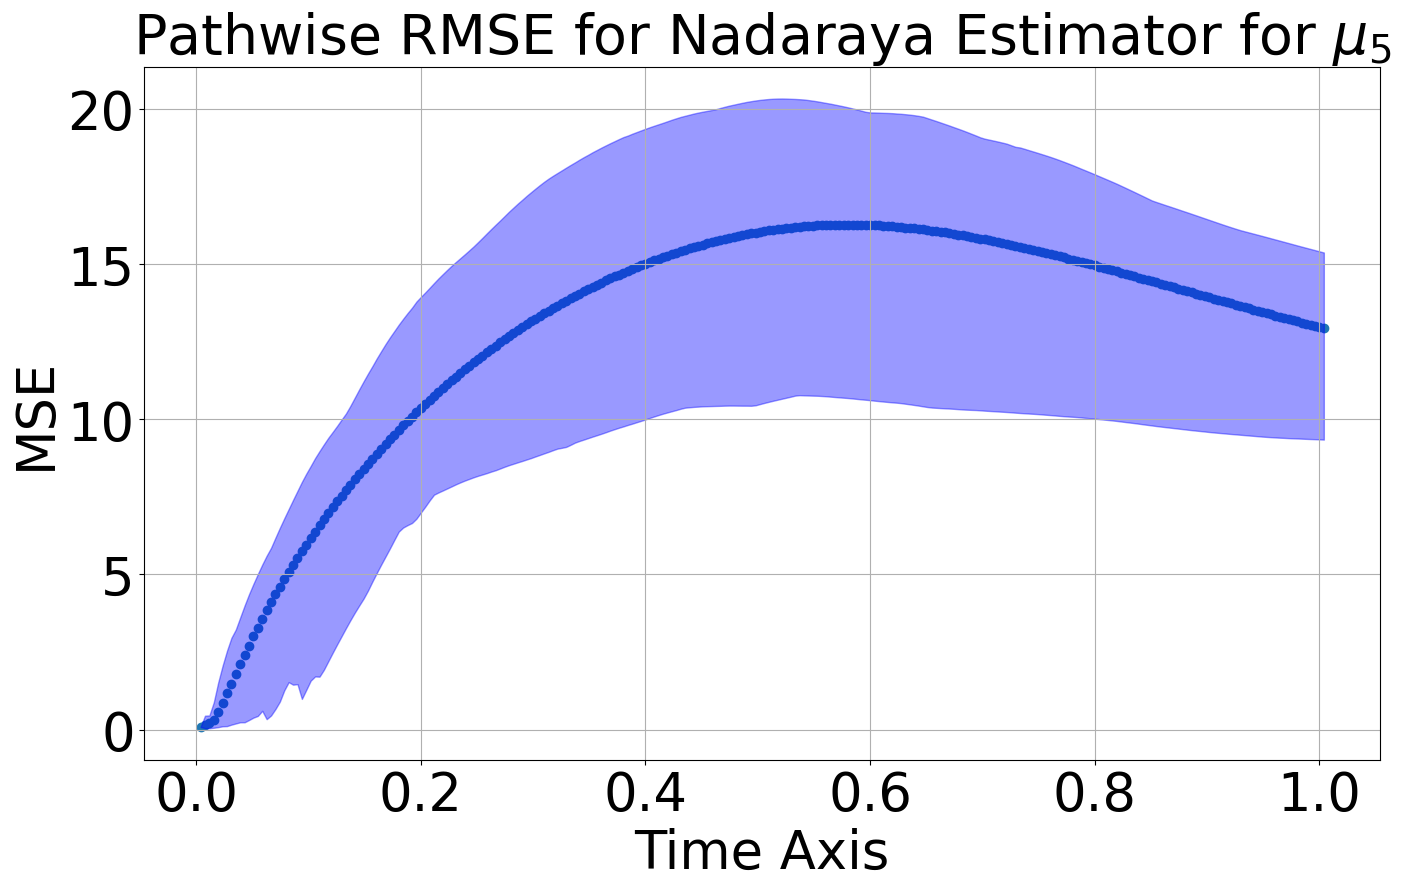

Final time cumulative MSE local-time error 12.930827041875782 with IQR ((9.34511929487688, 15.373827419974308))at bw 0.0031749 for 1.25FConst

12.76263121448329 0.0041919 12.930827041875782


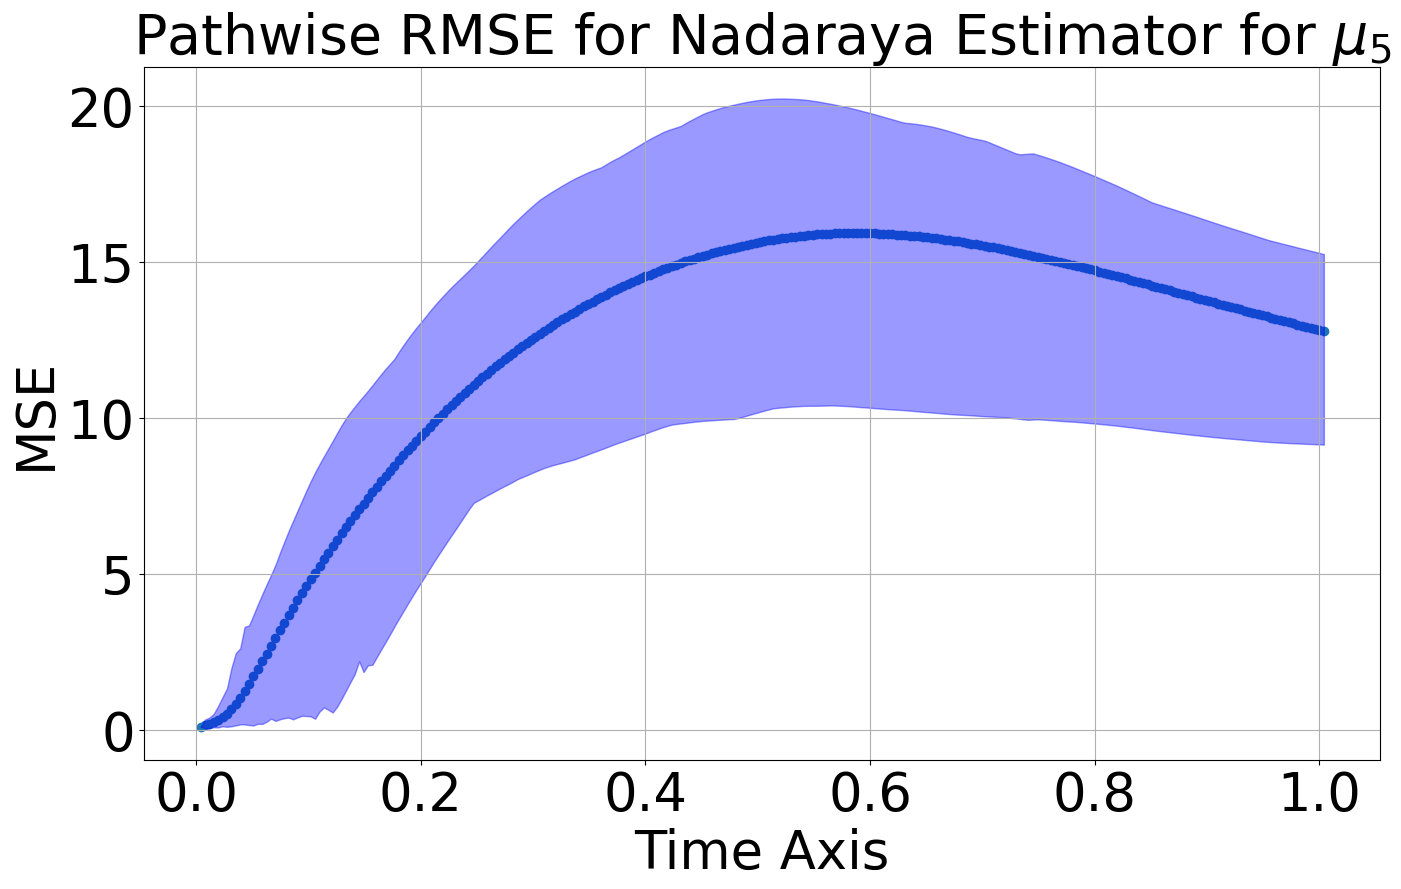

Final time cumulative MSE local-time error 12.76263121448329 with IQR ((9.13144166790011, 15.239442438426662))at bw 0.0041919 for 1.25FConst

12.458781843526742 0.0055348 12.76263121448329


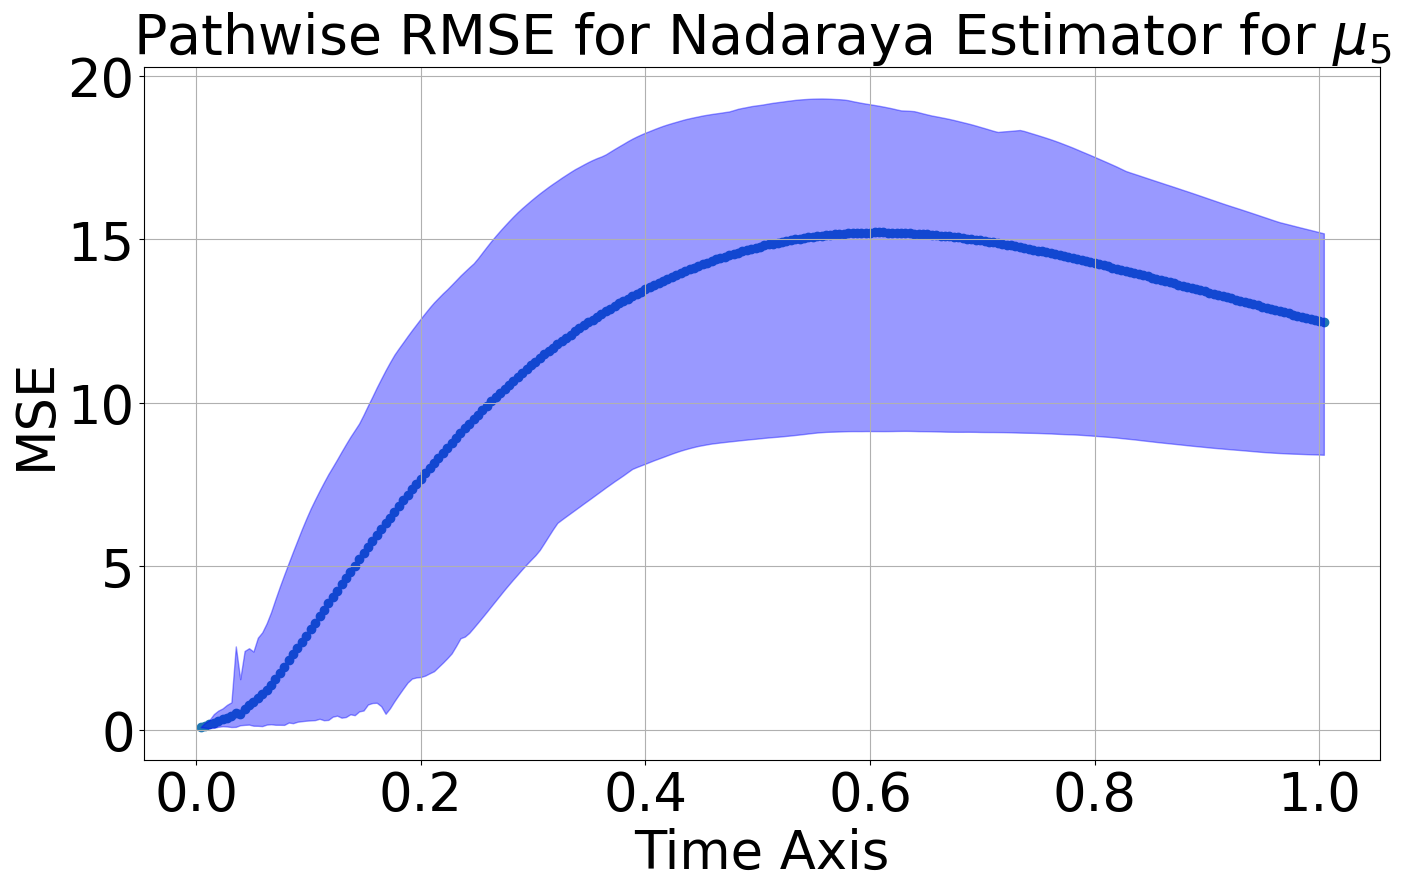

Final time cumulative MSE local-time error 12.458781843526742 with IQR ((8.41109316754296, 15.183144302083168))at bw 0.0055348 for 1.25FConst

11.871457704970528 0.0073079 12.458781843526742


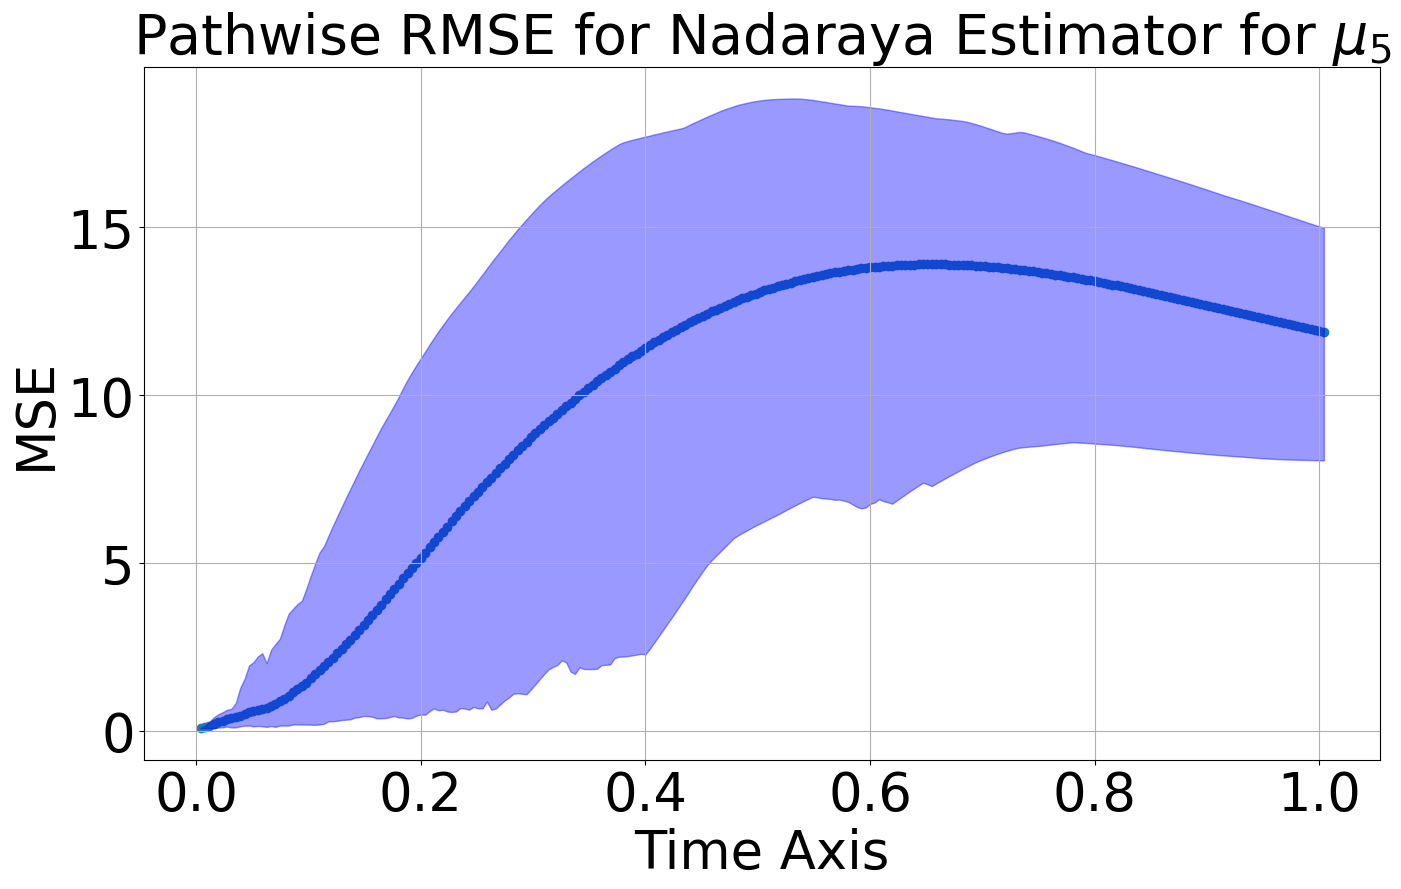

Final time cumulative MSE local-time error 11.871457704970528 with IQR ((8.055348169016272, 14.982145716008224))at bw 0.0073079 for 1.25FConst

10.481932474742074 0.009649 11.871457704970528


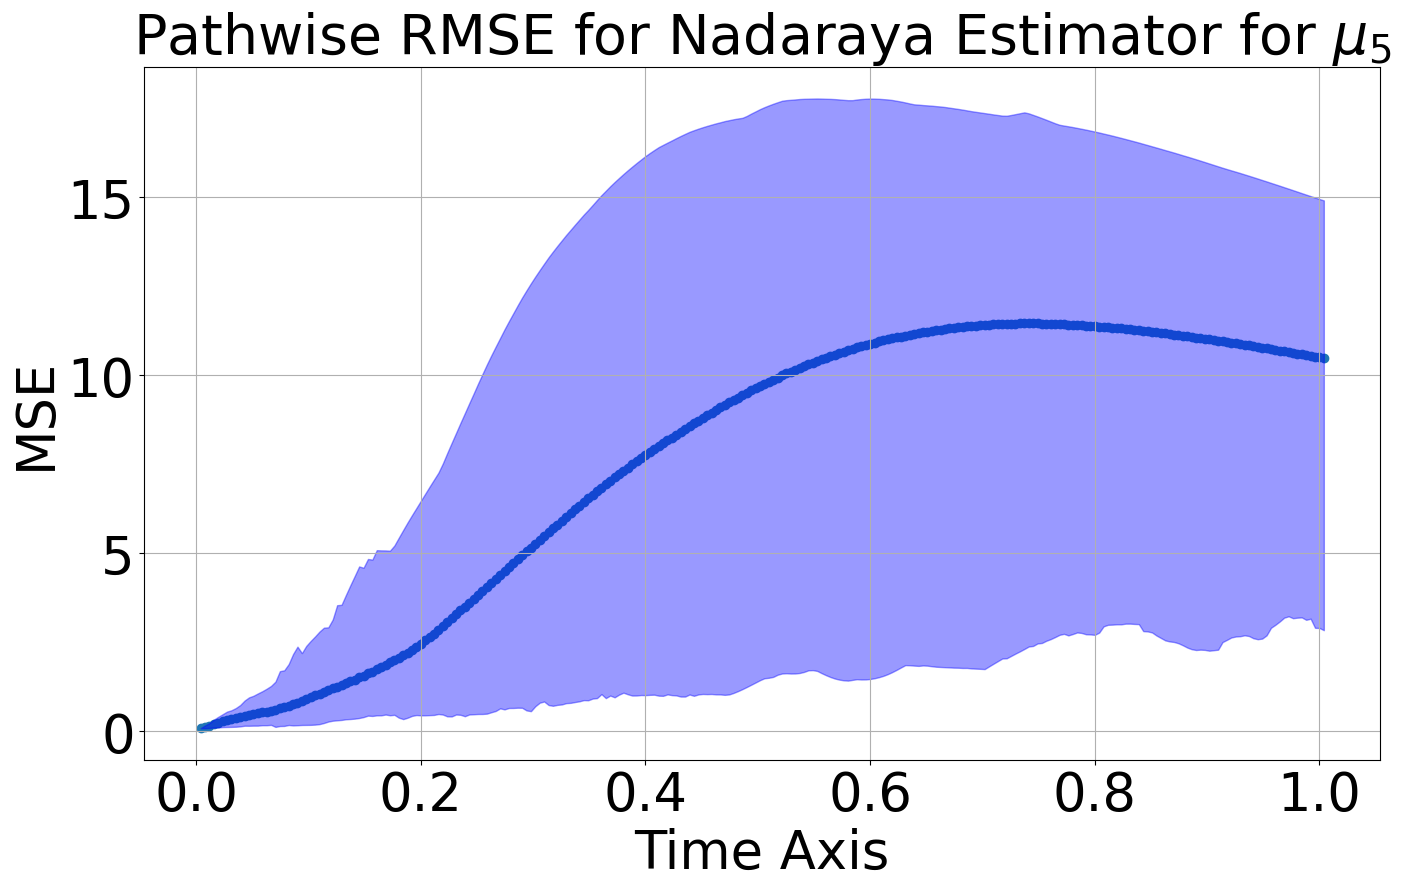

Final time cumulative MSE local-time error 10.481932474742074 with IQR ((2.8432325841208197, 14.908064967872178))at bw 0.009649 for 1.25FConst

8.162664466079649 0.0127401 10.481932474742074


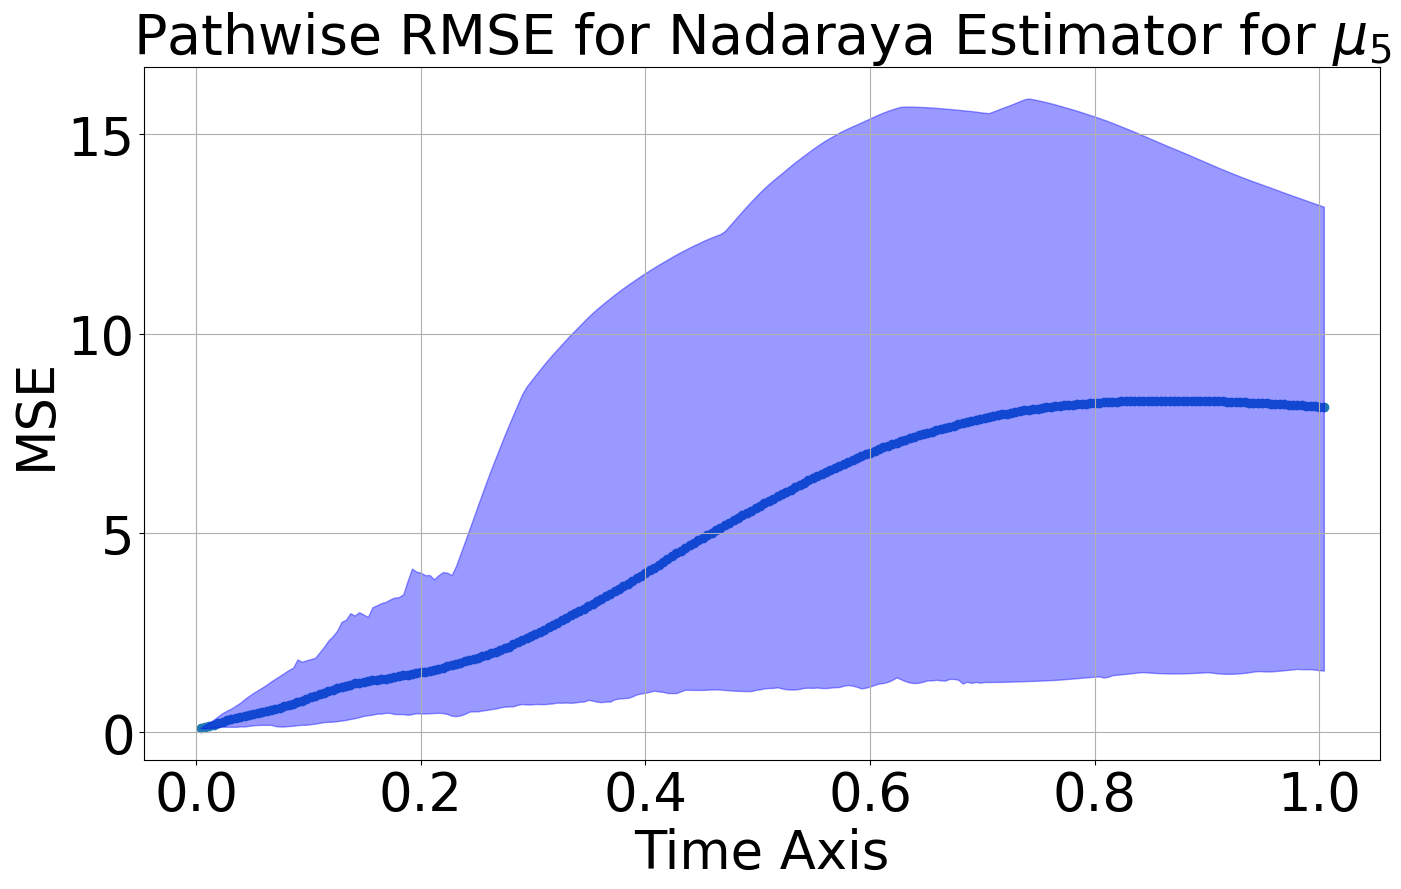

Final time cumulative MSE local-time error 8.162664466079649 with IQR ((1.547535128900295, 13.18130155145813))at bw 0.0127401 for 1.25FConst

5.358710408513398 0.0168214 8.162664466079649


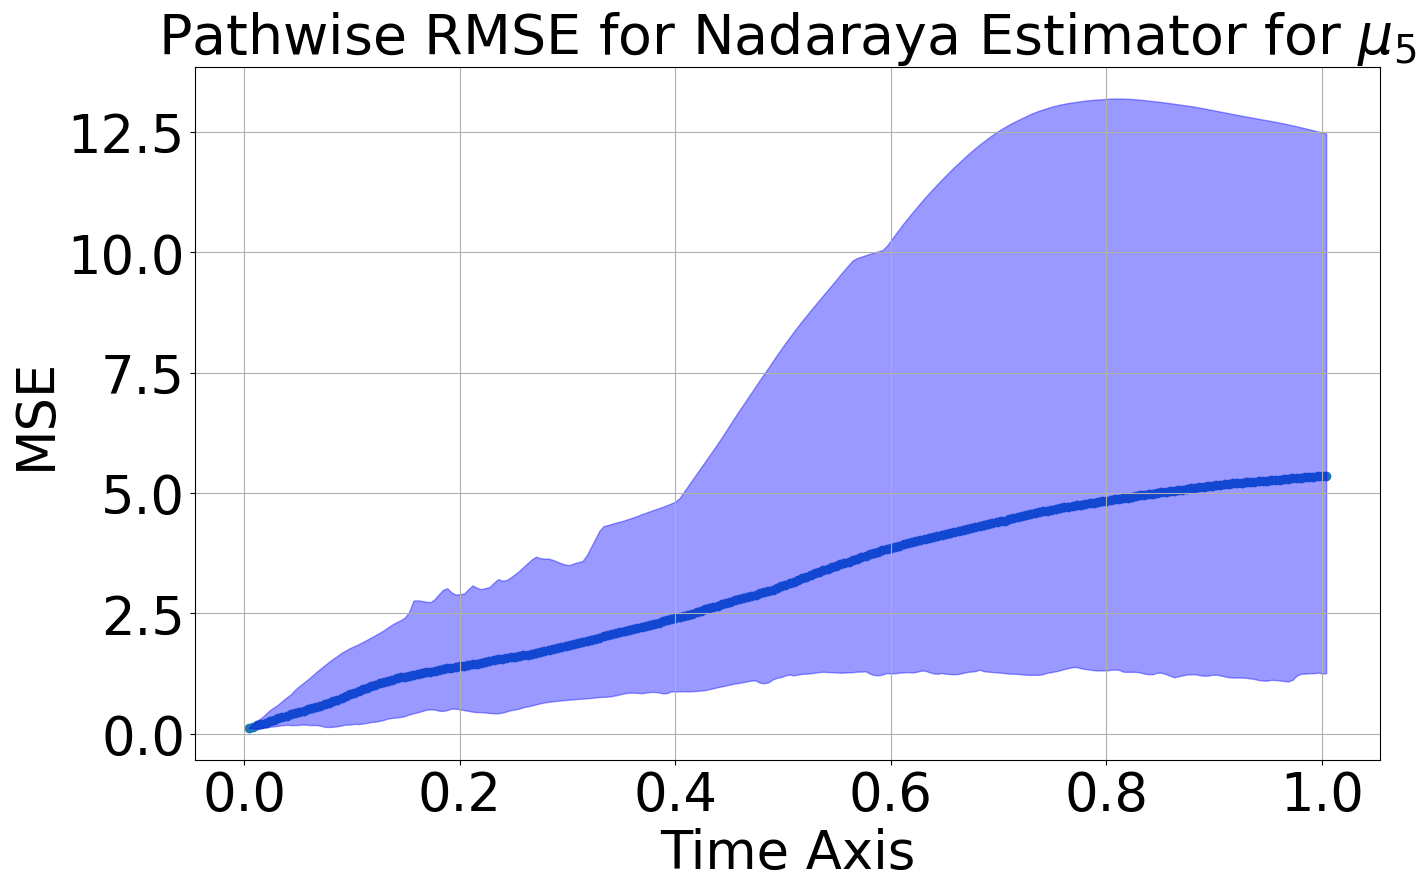

Final time cumulative MSE local-time error 5.358710408513398 with IQR ((1.2538173260197563, 12.46555181490388))at bw 0.0168214 for 1.25FConst

3.7248009159753774 0.0222102 5.358710408513398


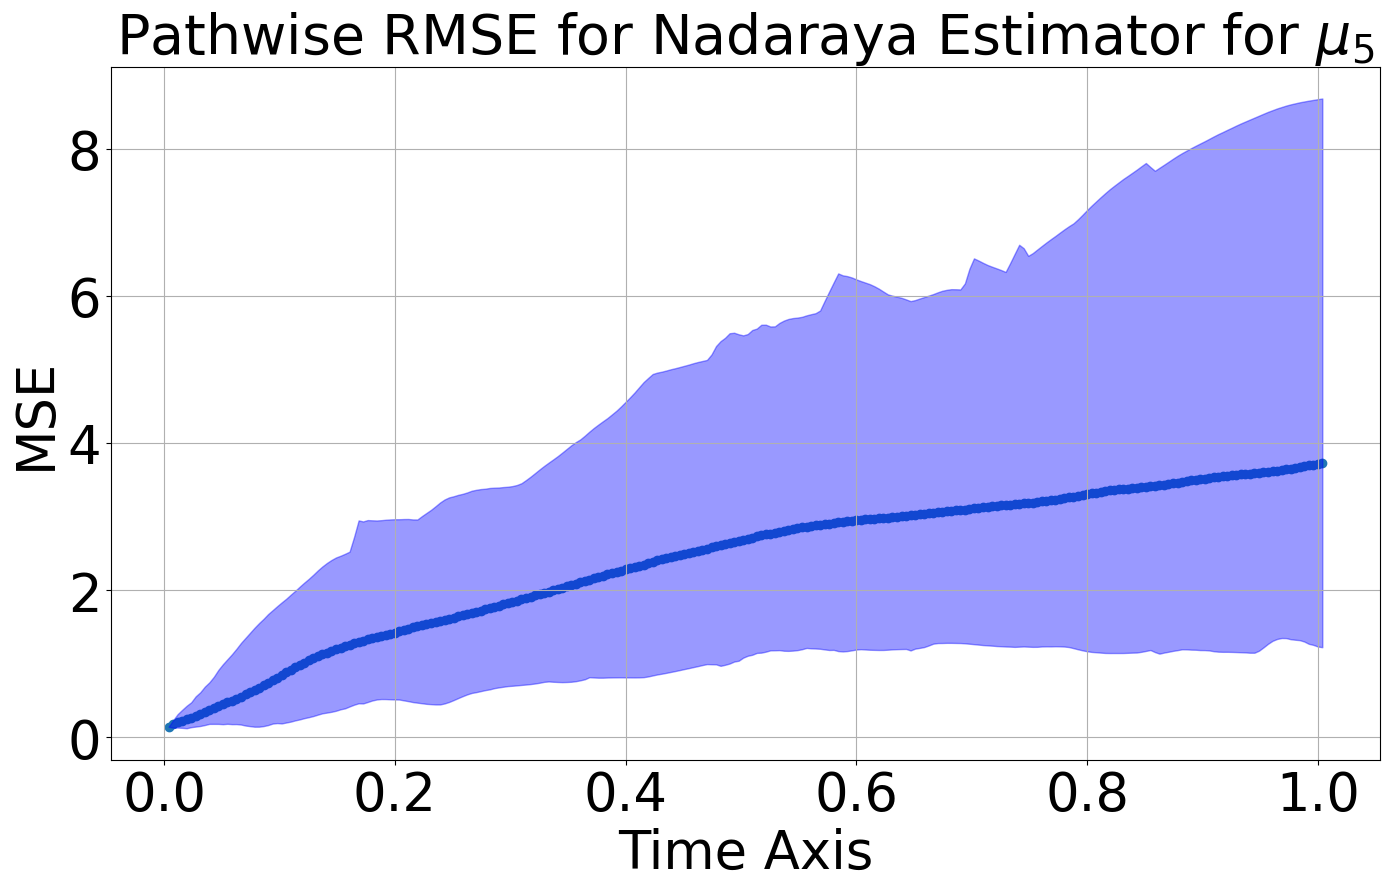

Final time cumulative MSE local-time error 3.7248009159753774 with IQR ((1.2229809576794615, 8.680685575649608))at bw 0.0222102 for 1.25FConst

3.358760082665762 0.0293252 3.7248009159753774


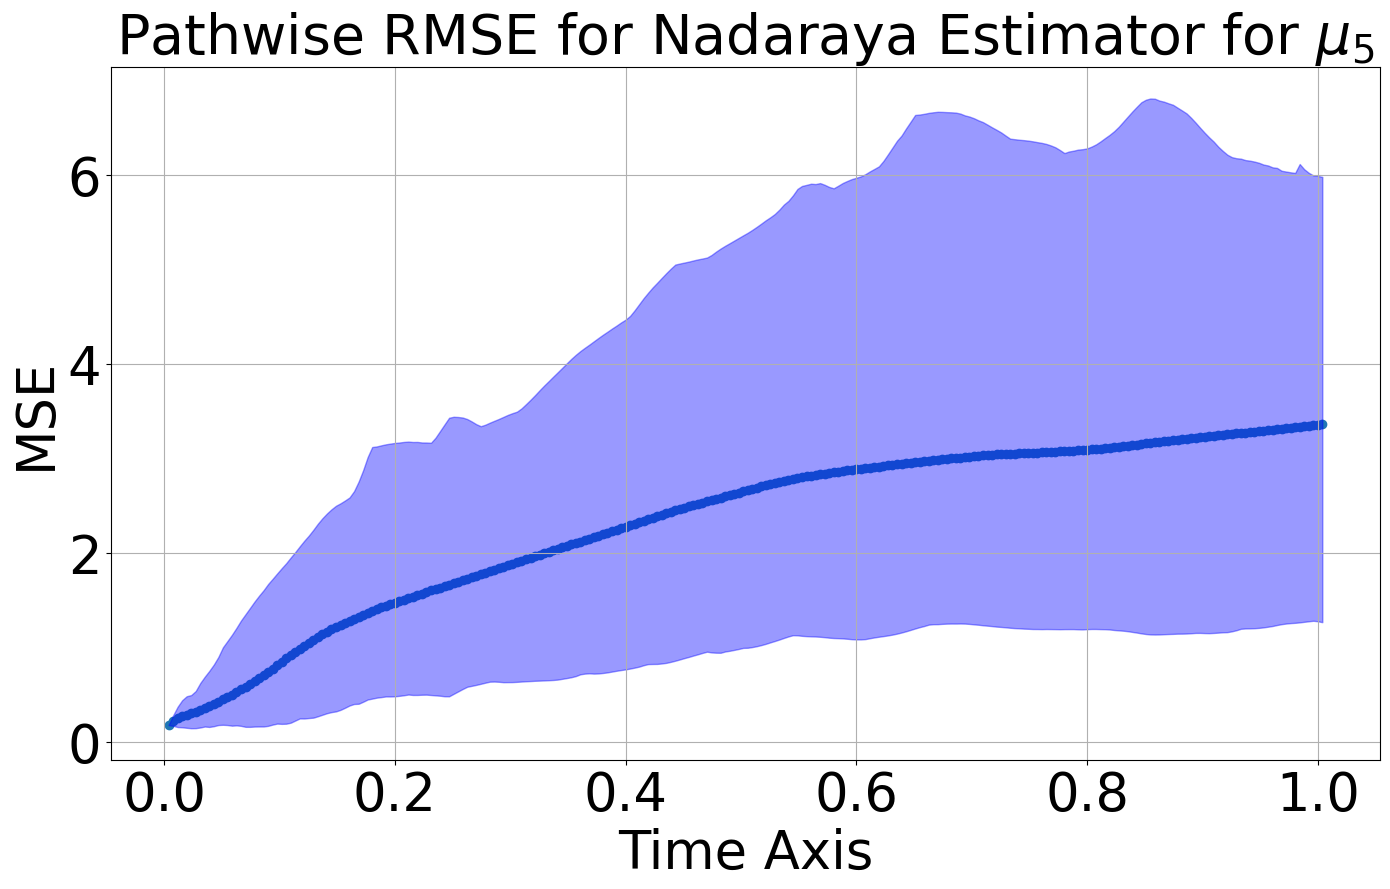

Final time cumulative MSE local-time error 3.358760082665762 with IQR ((1.264616093183681, 5.976893143113154))at bw 0.0293252 for 1.25FConst

3.2674067250459515 0.0387196 3.358760082665762


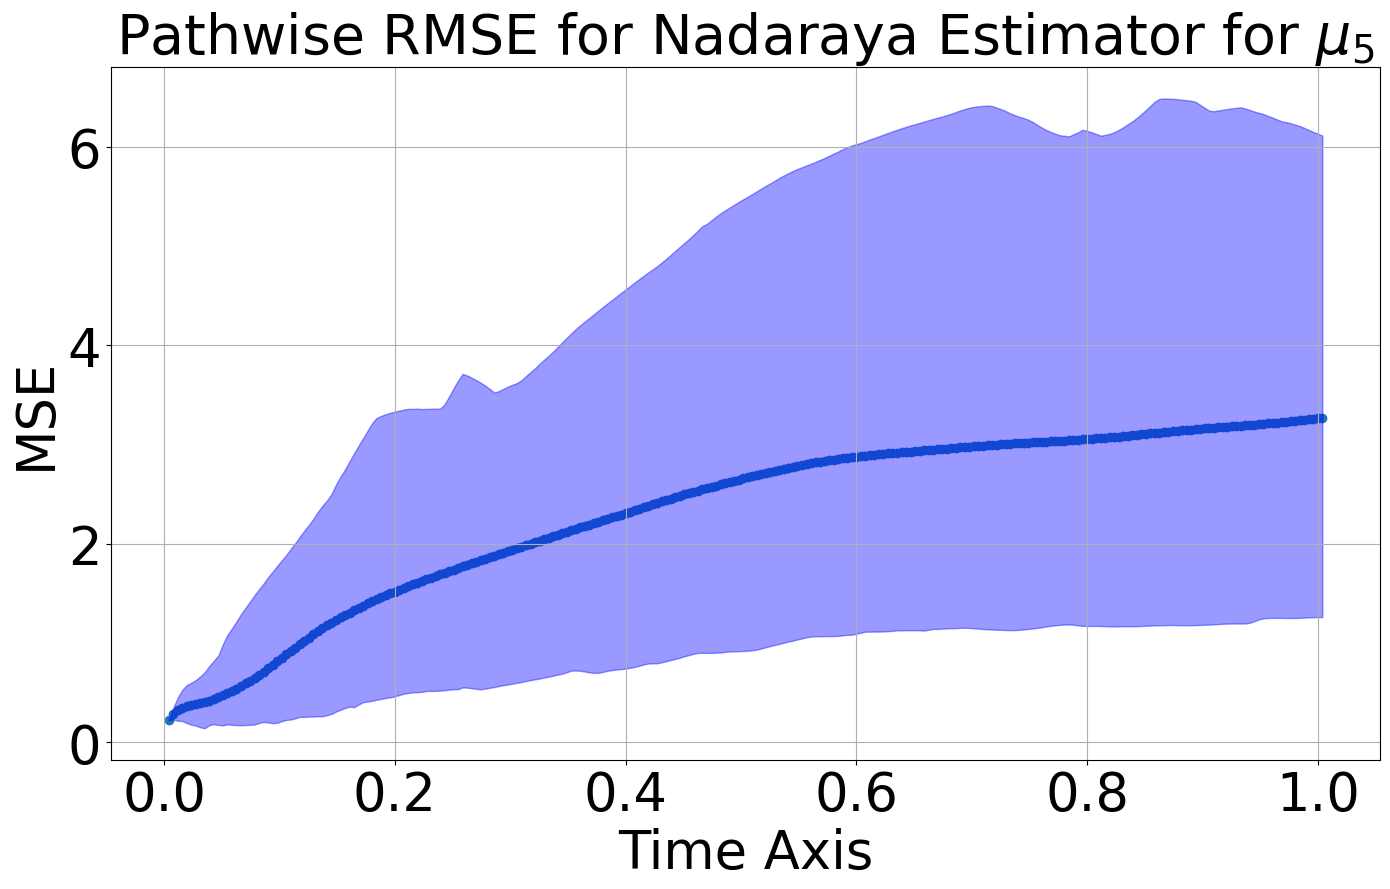

Final time cumulative MSE local-time error 3.2674067250459515 with IQR ((1.2601357603260028, 6.110761865593762))at bw 0.0387196 for 1.25FConst

3.267238765687754 0.0511235 3.2674067250459515


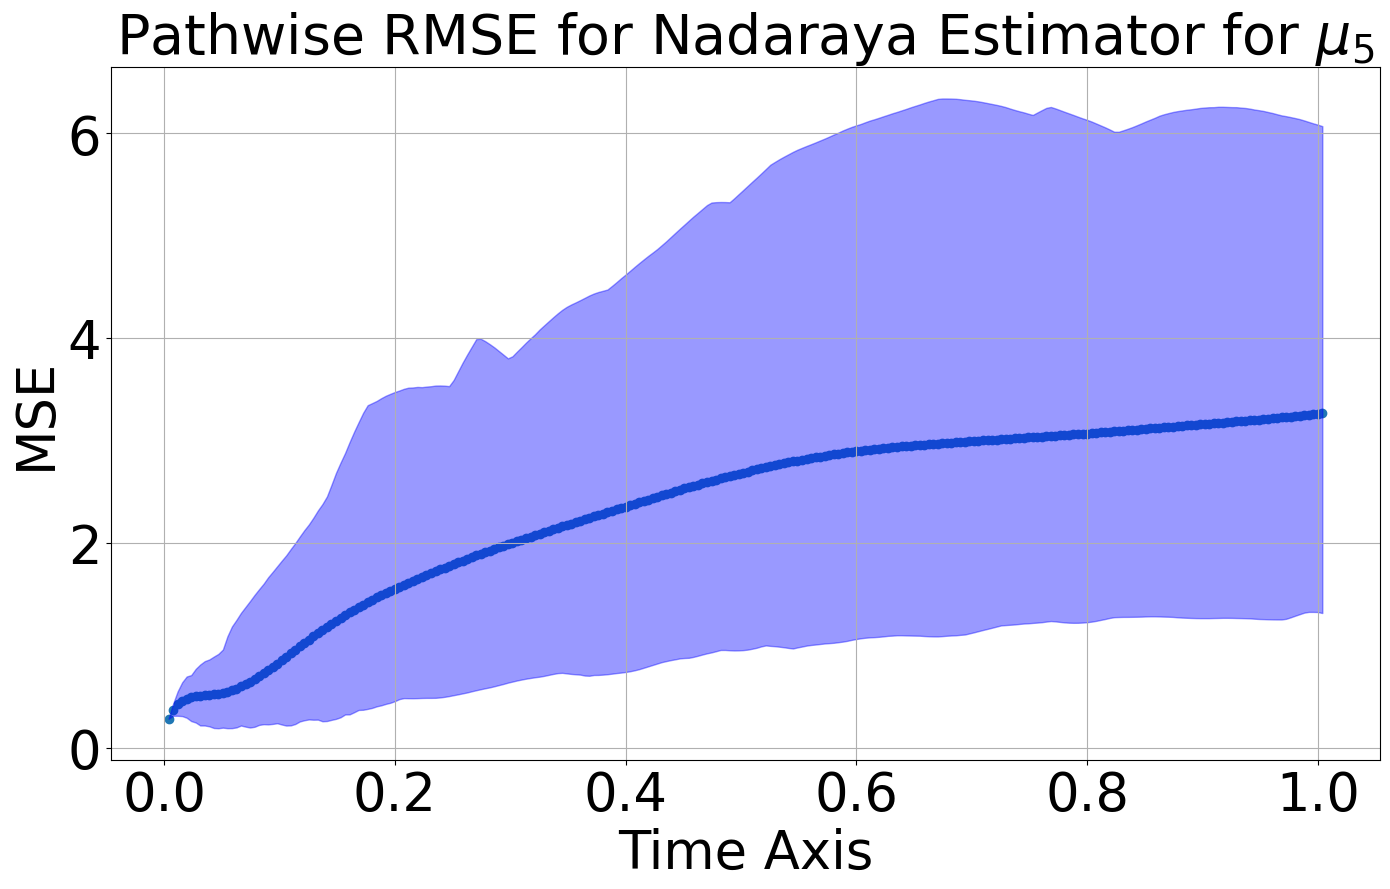

Final time cumulative MSE local-time error 3.267238765687754 with IQR ((1.3163001201470483, 6.0671108483579435))at bw 0.0511235 for 1.25FConst

3.3067035723702 0.067501 3.267238765687754
3.37711056490145 0.0891251 3.267238765687754


In [11]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/12DLnzChaosLessData/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [12]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

{'progress_name': 'idx',
 'span_units': 17.0,
 'wall_clock_h_total': 9.988091628087892,
 'wall_clock_per_unit_h': 0.5875348016522289,
 'cpu_avg_pct': 42.029568106312354,
 'cpu_peak_pct': 49.3,
 'ram_avg_gib': 226.83806664451848,
 'ram_peak_gib': 246.067764,
 'gpu_util_avg_pct': None,
 'gpu_util_peak_pct': None,
 'gpu_mem_avg_gib': None,
 'gpu_mem_peak_gib': None}